# Fit CO model to HD 98800 uv data

In [1]:
import os
import glob
import numpy as np
import astropy.units as un
import emcee
import scipy.optimize
import matplotlib.pyplot as plt
import corner
import galario.double as gd
from galario import arcsec
from uvplot import UVTable

import alma.image

%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
out_dir = 'rv_cube_uv/'

# few base assumptions
mstar = 1.28
distance = 44.9

## uv table extraction
This set of visibilities is off-center, just as the continuum data is.
```
for i in np.arange(0,41):
    uvplot.io.export_uvtable('uv-cube/uv-CO-ch{:02}.txt'.format(i), tb,
                             vis='hd98800.pcal1.CO.ms',split=split,
                             split_args={'spw': '0:{}'.format(i), 'vis':'hd98800.pcal1.CO.ms',
                                         'datacolumn': 'data', 'keepflags': False},
                             datacolumn='DATA')
```

In [3]:
# import the data, this assumes we're getting the output from uvplot
uv_dir = '../../../data/alma/hd98800-b6/uv-cube/'
files = glob.glob(uv_dir+'uv*.txt')

uvdata = []
rv = []
wavelength = []
for f in reversed(files):
    
    u, v, Re, Im, w = np.require( np.loadtxt(f, unpack=True),requirements=["C_CONTIGUOUS"])

    # meaning we can get the mean wavelength like so
    with open(f) as tmp:
        _ = tmp.readline()
        tmp = tmp.readline()

    wavelength_tmp = float(tmp.strip().split('=')[1])    
    u /= wavelength_tmp
    v /= wavelength_tmp
    wavelength.append(wavelength_tmp)
    
    freq = 2.99792458e+8/wavelength_tmp
    rv_tmp = ( (freq * un.Hz).to(un.km/un.s, equivalencies=un.doppler_radio(230538000000.0*un.Hz)) ).value
    rv.append(rv_tmp)

    # re-weight so that chi^2 for null model is 1
    reweight_factor = np.sum( ( Re**2.0 + Im**2.0) * w ) / len(w)
    w /= reweight_factor

    print('{}, {} rows, \twave {:9.7f}mm ({:9.2f}MHz, '
          '{:5.2f} km/s),\treweight factor {:g}'.format(os.path.basename(f),len(w),
                                                        wavelength_tmp*1e3, freq/1e6, rv_tmp,
                                                        reweight_factor))

    uvdata.append( (u, v, Re, Im, w) )

uv-CO-ch40.txt, 223552 rows, 	wave 1.3003719mm (230543.62MHz, -7.31 km/s),	reweight factor 0.978523
uv-CO-ch39.txt, 223552 rows, 	wave 1.3003747mm (230543.13MHz, -6.68 km/s),	reweight factor 0.976512
uv-CO-ch38.txt, 223552 rows, 	wave 1.3003774mm (230542.65MHz, -6.04 km/s),	reweight factor 0.981461
uv-CO-ch37.txt, 223552 rows, 	wave 1.3003802mm (230542.16MHz, -5.41 km/s),	reweight factor 0.980416
uv-CO-ch36.txt, 223552 rows, 	wave 1.3003830mm (230541.67MHz, -4.77 km/s),	reweight factor 0.98448
uv-CO-ch35.txt, 223552 rows, 	wave 1.3003857mm (230541.18MHz, -4.14 km/s),	reweight factor 0.987131
uv-CO-ch34.txt, 223552 rows, 	wave 1.3003885mm (230540.69MHz, -3.50 km/s),	reweight factor 0.992214
uv-CO-ch33.txt, 223552 rows, 	wave 1.3003912mm (230540.21MHz, -2.87 km/s),	reweight factor 0.992856
uv-CO-ch32.txt, 223552 rows, 	wave 1.3003940mm (230539.72MHz, -2.23 km/s),	reweight factor 0.988469
uv-CO-ch31.txt, 223552 rows, 	wave 1.3003967mm (230539.23MHz, -1.60 km/s),	reweight factor 0.987224
u

In [4]:
# average rv step (checking that the steps are about the same)
n_chan = len(rv)
d_rv = np.mean(np.diff(rv))
print(np.min(np.diff(rv))/d_rv, np.max(np.diff(rv))/d_rv, d_rv)

0.9999967347597535 1.0000027861934127 0.6349172194256638


In [5]:
# set image properties, can cut dxy down for speed (at the cost of reduced accuracy)
nxy, dxy = gd.get_image_size(u, v, verbose=True, f_max=2.5)
dxy_arcsec = dxy / arcsec

dxy:4.595247e-03arcsec	nxy_MRS:2048
nxy_MRS: matrix size to have FOV > f_min * MRS, where f_min:5.0 and MRS:1.882213e+00arcsec


model:los_image_axisym with density:power_2d and emit:rj_tail
parameters are ['$x_0$', '$y_0$', '$\\Omega$', '$i$', '$F$', '$r_{in}$', '$r_{out}$', '$\\alpha$']
rmax not set, run compute_rmax before generating images
radial r_max: 38 pix at -14.3614095303369,133.52718749370695
model x,y,z extent 35, 39, 37


<IPython.core.display.Javascript object>


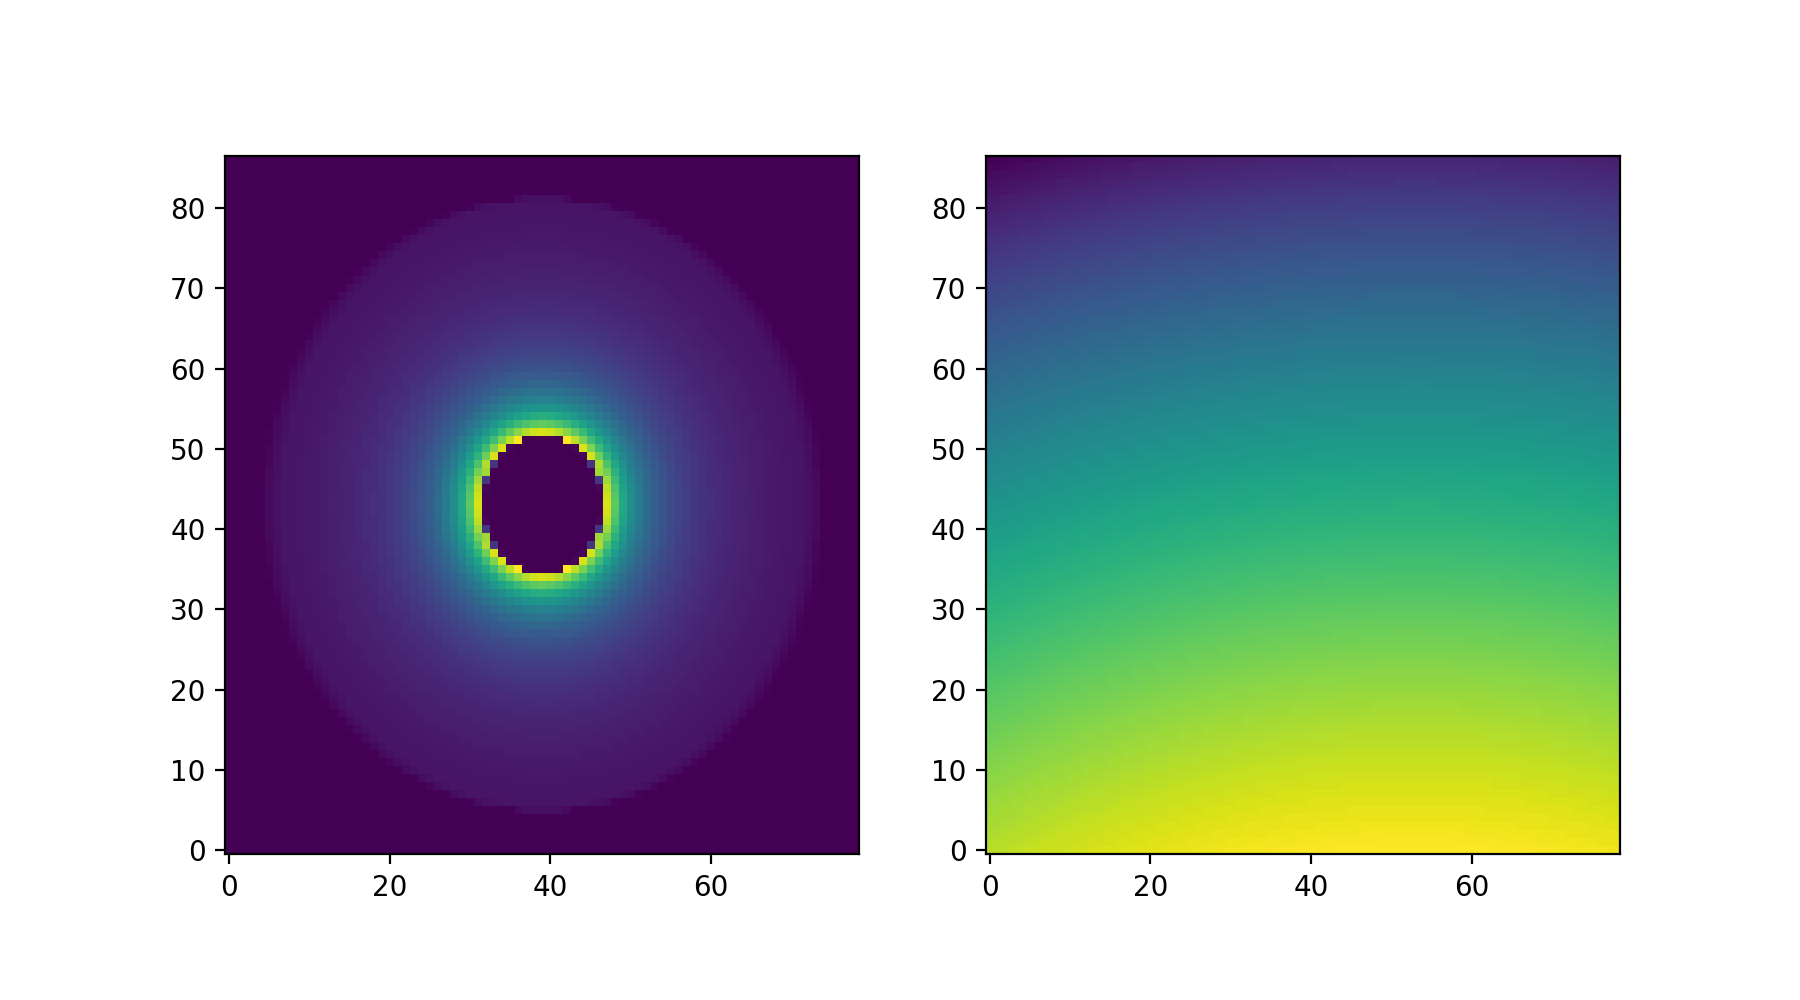

In [6]:
# model cube
ii = alma.image.Image(arcsec_pix=dxy_arcsec, image_size=(nxy,nxy), wavelength=np.mean(wavelength),
                      dens_model='power_2d', #dens_args={'box_half_height':0.05},
                      emit_model='rj_tail', z_fact=2)

p0 = np.array([-0.06599422 , 0.61359037, 18.26998897, 26.73216699 , 0.2620663 ,  0.03936594,
  0.17536987, -2.5359813 ,   5.30420582])

ii.compute_rmax(p0[:-1], tol=1e-2, expand=5, zero_node=True)

fig,ax = plt.subplots(1,2, figsize=(9,5))
ax[0].imshow(ii.image_galario(p0[3:-1])[ii.cc_gal], origin='bottom')
ax[1].imshow(ii.pb_galario[ii.cc_gal], origin='bottom')

(3, 3, 3)


<IPython.core.display.Javascript object>


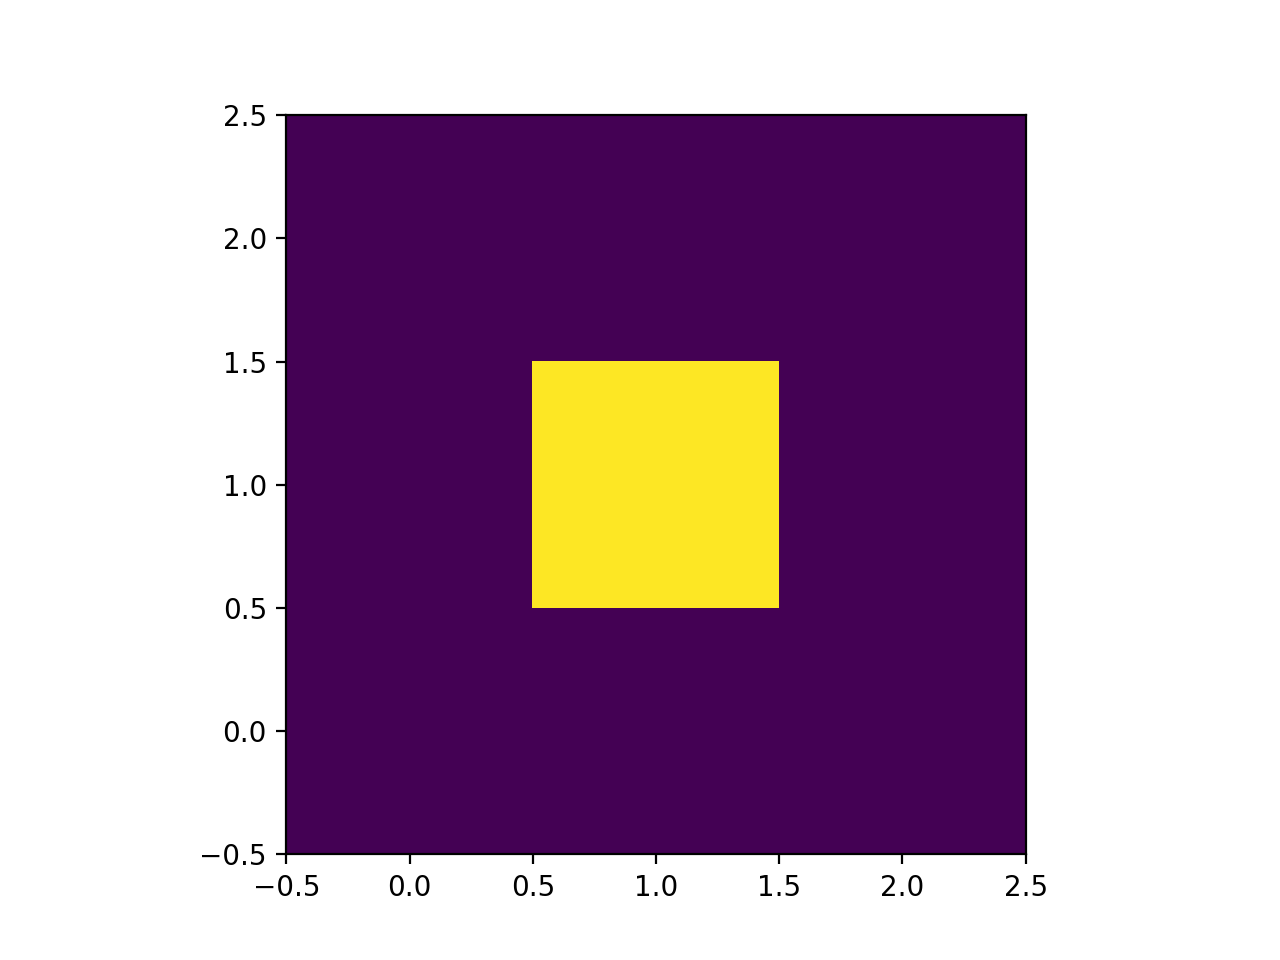

In [7]:
# account for non-independent channels, with FWHM=2 channels in spectral direction
kern = np.zeros((3,3))
kern[1,1] = 1.0
kern3d = np.stack( (0.5*kern, kern, 0.5*kern), axis=2 )
kern3d /= np.sum(kern3d)
print(kern3d.shape)

fig,ax = plt.subplots()
ax.imshow(kern, origin='bottom')

In [8]:
labels = np.append(ii.params,['$v_{sys}$'])
p_ranges = ii.p_ranges + [[0,10]]

for i in range(len(p0)):
    print('{:g}  \t{}  \t{}'.format(p0[i],p_ranges[i],labels[i]))

-0.0659942  	[-inf, inf]  	$x_0$
0.61359  	[-inf, inf]  	$y_0$
18.27  	[-270, 270]  	$\Omega$
26.7322  	[0.0, 120]  	$i$
0.262066  	[0.0, inf]  	$F$
0.0393659  	[0.0, inf]  	$r_{in}$
0.17537  	[0.0, inf]  	$r_{out}$
-2.53598  	[-inf, inf]  	$\alpha$
5.30421  	[0, 10]  	$v_{sys}$


In [9]:
def conv_rv_cube(p):
    '''Generate centered and unrotated cube.'''
    rvcube = ii.rv_cube_galario(p[3:-1], rv_min=np.min(rv)-d_rv/2.0,
                                dv=d_rv, n_chan=n_chan,
                                mstar=mstar, distance=distance, v_sys=p[-1])
    # apply optical depth
#     rvcube = 1 - np.exp(-rvcube/p[-2])
#     rvcube = p[4] * rvcube / np.sum(rvcube)
    # convolve in spectral dimension
    rvcube = scipy.ndimage.filters.convolve(rvcube, kern3d)  
    rvcube = np.rollaxis(rvcube, 2)
    return rvcube

def lnlike(p):
    """ Log of posterior probability function."""

    for x,r in zip(p, p_ranges):
        if x < r[0] or x > r[1]:
            return -np.inf
    if  p[5] > p[6]:
        return -np.inf

    rvcube = conv_rv_cube(p)
    if not np.isfinite(np.sum(rvcube)):
        return -np.inf
    
    # compute visibility chi^2 across channels
    chi2 = 0.0
    for i, tmp in enumerate(zip(rvcube, uvdata)):

        im, vis = tmp
        u, v, Re, Im, w = vis
            
        # galario translates and rotates it for us
        chi2 += gd.chi2Image(im * ii.pb_galario, dxy, u, v, Re, Im, w,
                             dRA = p[0]*arcsec, dDec = p[1]*arcsec, PA = np.deg2rad(p[2]) )

    # include factor sqrt(2.667**2) for correlated noise in channels
    return -0.5 * chi2 / 2.667

nlnlike = lambda p: -lnlike(p)

In [10]:
%timeit lnlike(p0)
# lnlike(p0)

14.2 s ± 603 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
# res = scipy.optimize.minimize(nlnlike, par, method='Nelder-Mead', options={'maxiter':50})

# print(res['message'],-res['fun'])
# print(res['x'])
# par = np.array(res['x'])

Maximum number of iterations has been exceeded. -1606592.4515707754
[-0.06400407  0.62318548 22.97052685 26.43779737  0.19941146  0.03799817
  0.16029861 -2.35000091  0.1044742   5.72459277]


In [ ]:
# set up and run mcmc fitting
# with >1 thread this seems to crash if a prior call to ii.rv_cube has been made, no idea why
ndim = len(p0)          # number of dimensions
nwalkers = 64           # number of walkers
nsteps =  2000           # total number of MCMC steps
nthreads = 4            # CPU threads that emcee should use

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike, threads=nthreads)

# initialize the walkers with an ndim-dimensional Gaussian ball
pos = [p0 + p0*0.01*np.random.randn(ndim) for i in range(nwalkers)]

# execute the MCMC
pos, prob, state = sampler.run_mcmc(pos, nsteps)

In [ ]:
# save the chains to file
np.savez_compressed(out_dir+'rv_cube-uv-chains.npz', sampler.chain, sampler.lnprobability)

In [10]:
# load previous results
tmp = np.load('rv_cube_uv/rv_cube-uv-chains.npz')
chain = tmp['arr_0']
lnprobability = tmp['arr_1']
ndim = chain.shape[2]
nwalkers = chain.shape[0]
nsteps = chain.shape[1]
chain.shape

(64, 2000, 9)

<IPython.core.display.Javascript object>


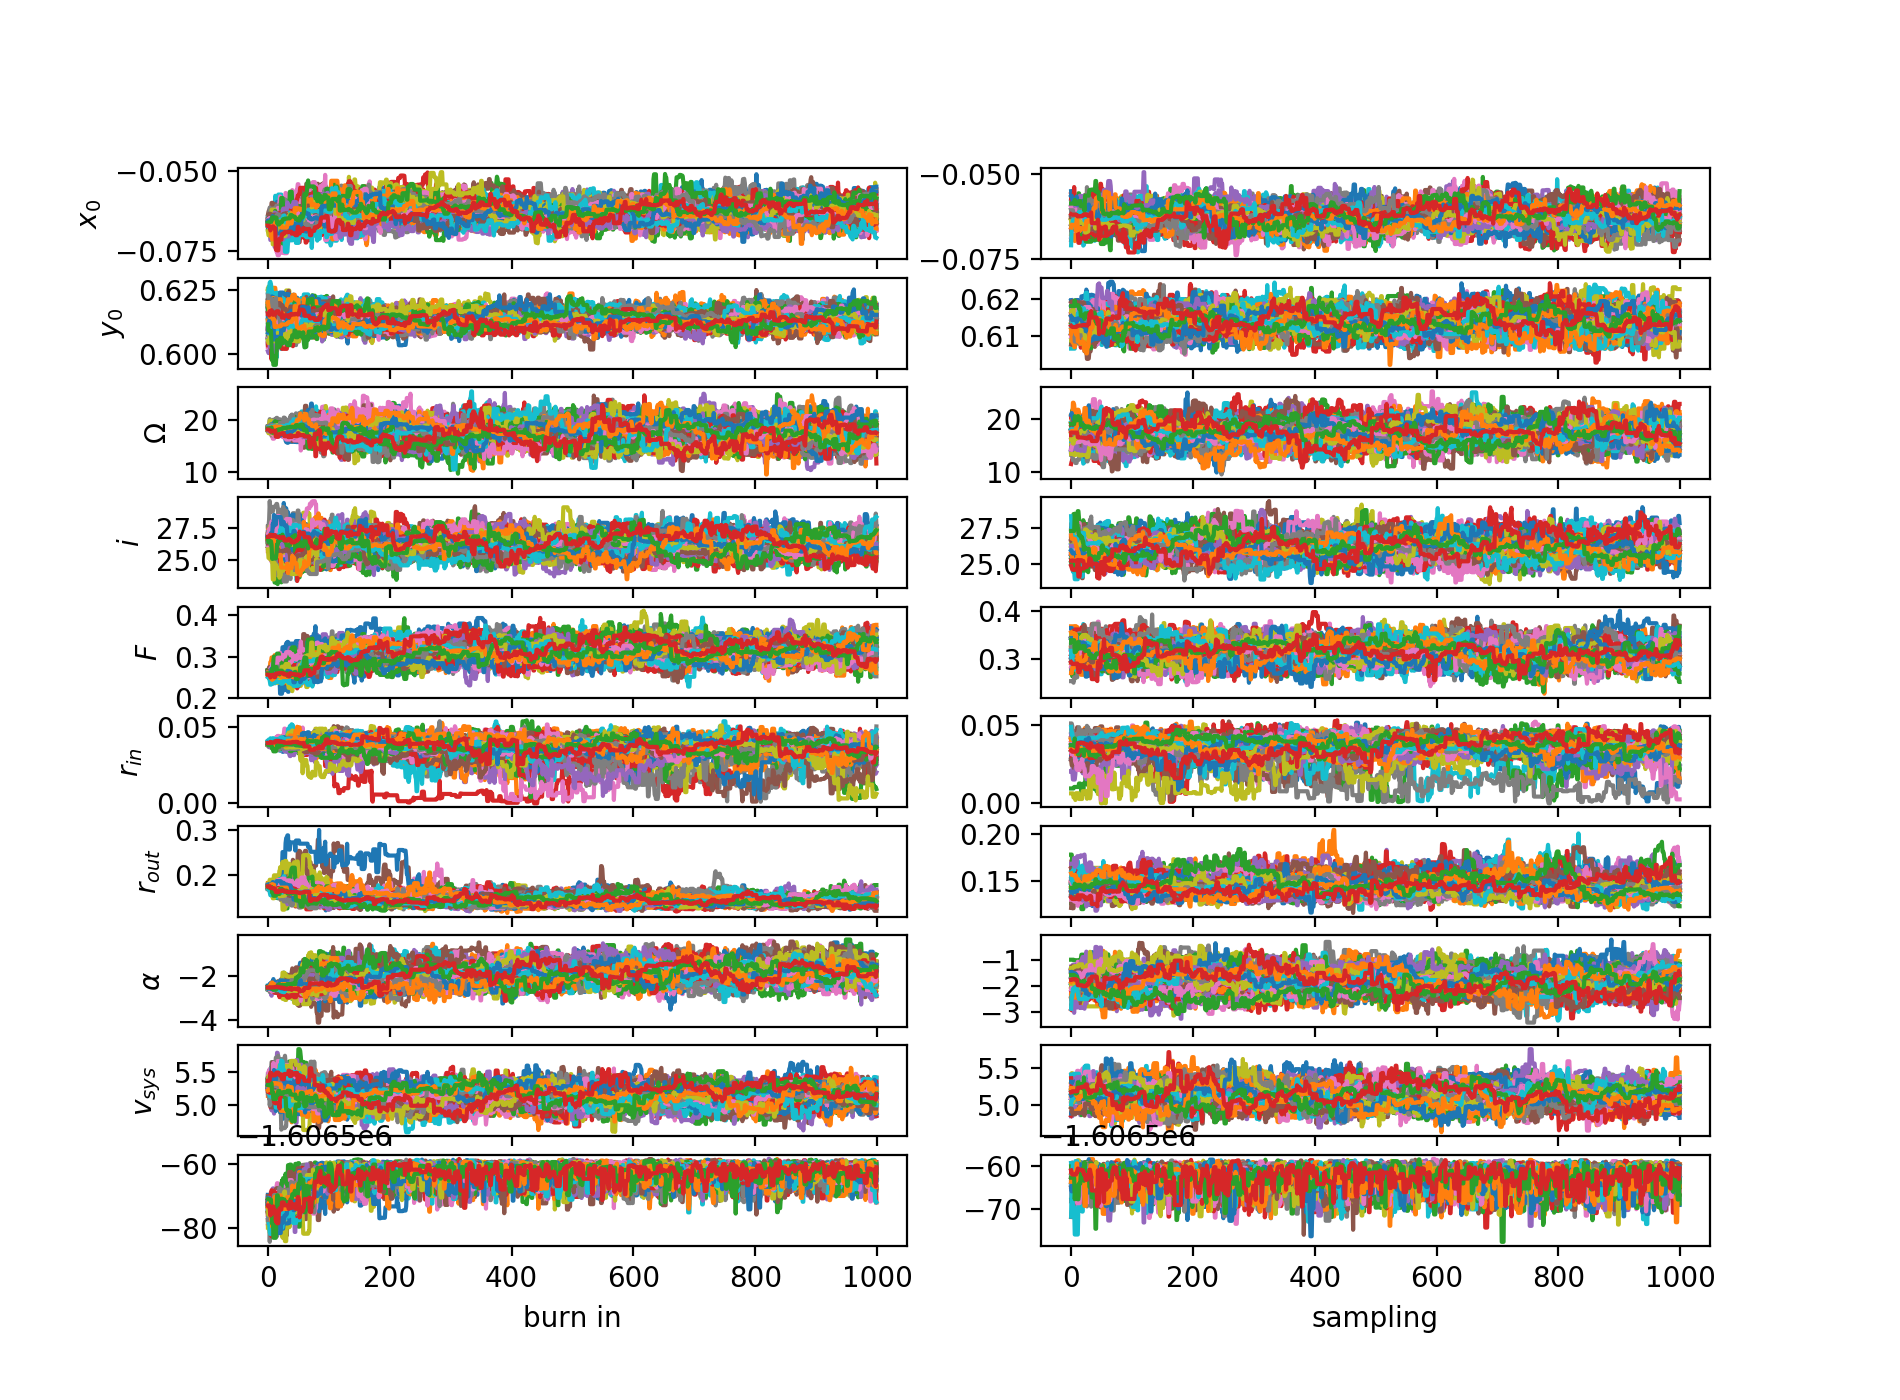

In [11]:
# see what the chains look like, skip a burn in period if desired
burn = 1000
fig,ax = plt.subplots(ndim+1,2,figsize=(9.5,7),sharex='col',sharey=False)

for j in range(nwalkers):
    ax[-1,0].plot(lnprobability[j,:burn])
    for i in range(ndim):
        ax[i,0].plot(chain[j,:burn,i])
        ax[i,0].set_ylabel(labels[i])

for j in range(nwalkers):
    ax[-1,1].plot(lnprobability[j,burn:])
    for i in range(ndim):
        ax[i,1].plot(chain[j,burn:,i])
#         ax[i,1].set_ylabel(ii.params[i])

ax[-1,0].set_xlabel('burn in')
ax[-1,1].set_xlabel('sampling')
fig.savefig(out_dir+'rv_cube-uv-chains.png')

<IPython.core.display.Javascript object>


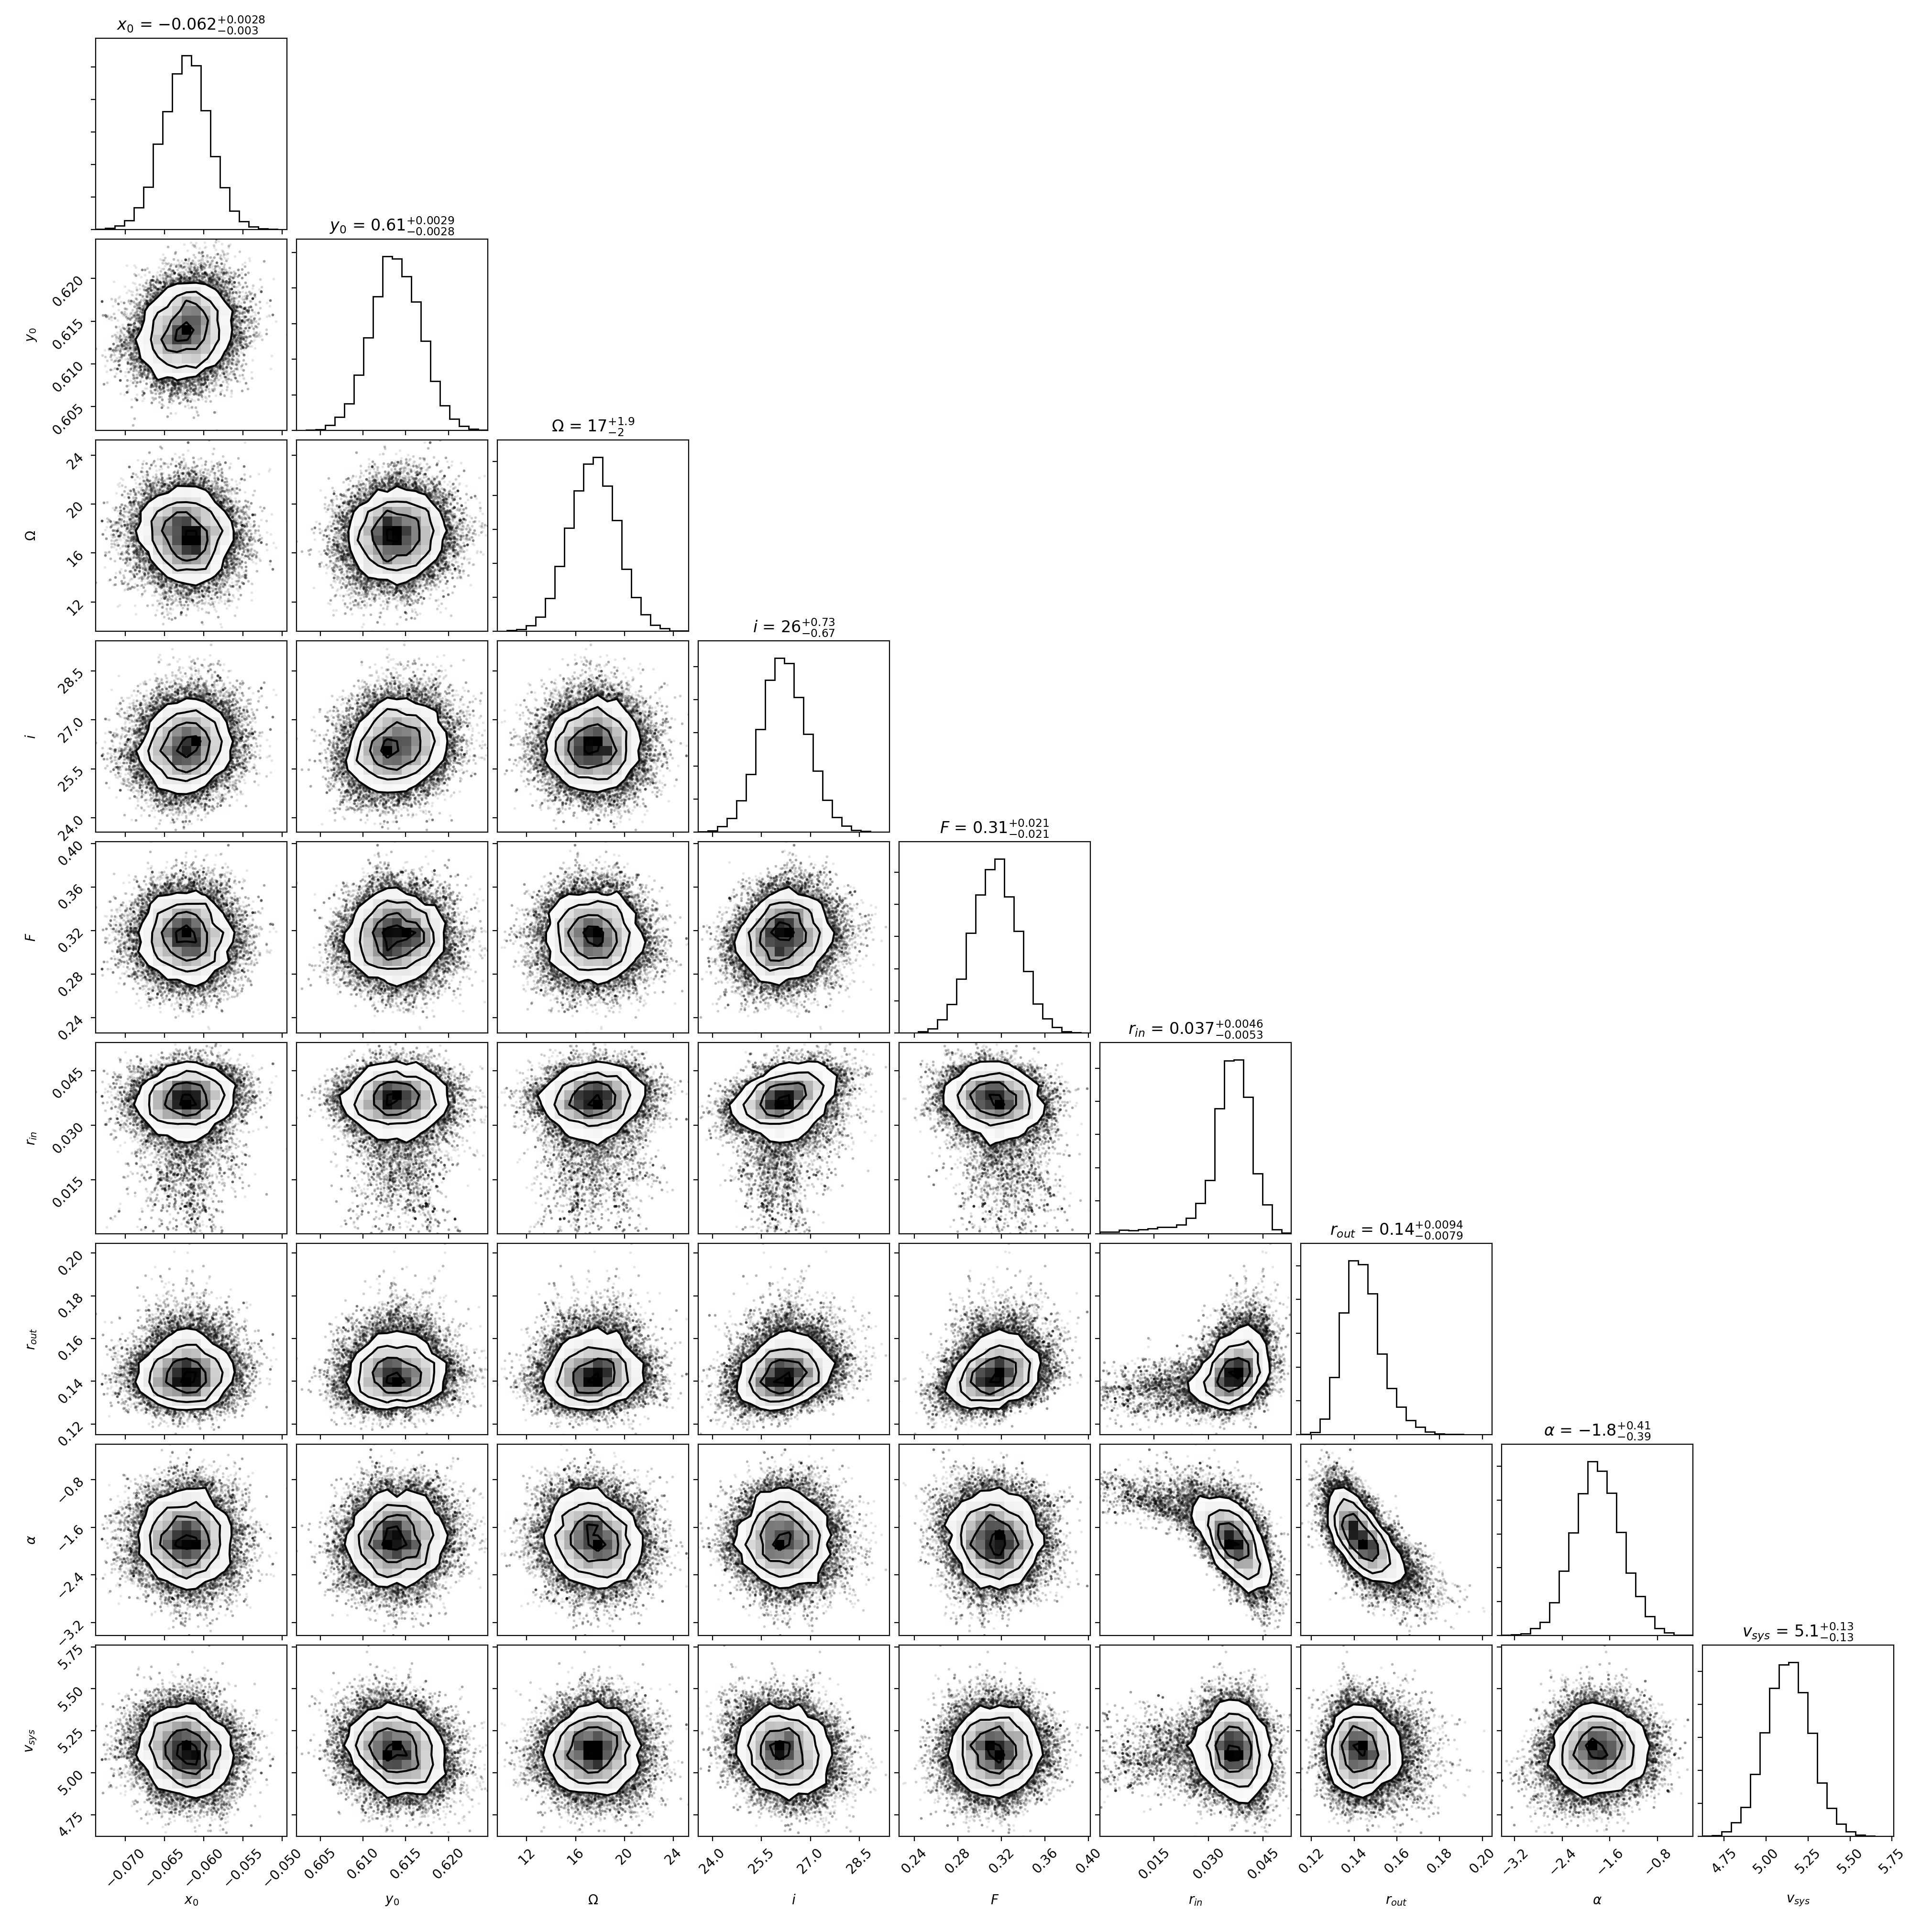

In [12]:
# make the corner plot
fig = corner.corner(chain[:,burn:,:].reshape((-1,ndim)), labels=labels,
                    show_titles=True, title_fmt='.2g')

fig.savefig(out_dir+'rv_cube-uv-corner.pdf')

In [13]:
# get the best fit parameters
i = np.unravel_index(np.argmax(lnprobability), lnprobability.shape)
p = chain[i]
s = np.std(chain[:,burn:,:].reshape((-1,ndim)),axis=0)
print(p)
print(s)

[-0.06280318  0.61326247 17.67824145 25.90422239  0.31402719  0.03689978
  0.14236012 -1.79574828  5.18459188]
[0.00295733 0.00287164 1.95024283 0.71589976 0.02106486 0.00671585
 0.00926518 0.40767747 0.13495546]


In [14]:
# and median, uncertainty ranges
med = np.percentile(chain[:,burn:,:].reshape((-1,ndim)), 50, axis=0)
lo = med - np.percentile(chain[:,burn:,:].reshape((-1,ndim)), 16, axis=0)
hi = np.percentile(chain[:,burn:,:].reshape((-1,ndim)), 84, axis=0) - med
for pn,m,l,h in zip(labels,med,lo,hi):
    print('{}\t{:g} - {:g} + {:g}'.format(pn,m,l,h))
    
# latex
for pn,m,l,h in zip(labels,med,lo,hi):
    print('{} & {:g} & {:g} \\\\'.format(pn,m,(l+h)/2.))

$x_0$	-0.0622029 - 0.00301768 + 0.00280268
$y_0$	0.613843 - 0.00279677 + 0.00292743
$\Omega$	17.47 - 1.95297 + 1.90492
$i$	26.182 - 0.667609 + 0.732348
$F$	0.314403 - 0.021011 + 0.0208679
$r_{in}$	0.0366505 - 0.00527361 + 0.00460323
$r_{out}$	0.143404 - 0.00790817 + 0.00937445
$\alpha$	-1.81142 - 0.392463 + 0.407777
$v_{sys}$	5.13126 - 0.134252 + 0.132444
$x_0$ & -0.0622029 & 0.00291018 \\
$y_0$ & 0.613843 & 0.0028621 \\
$\Omega$ & 17.47 & 1.92895 \\
$i$ & 26.182 & 0.699978 \\
$F$ & 0.314403 & 0.0209394 \\
$r_{in}$ & 0.0366505 & 0.00493842 \\
$r_{out}$ & 0.143404 & 0.00864131 \\
$\alpha$ & -1.81142 & 0.40012 \\
$v_{sys}$ & 5.13126 & 0.133348 \\


In [16]:
# save the visibilities for subtraction from the data
vis_mod = np.zeros((len(rv),len(u)), dtype=np.complex)
rvcube = conv_rv_cube(p)

for i, tmp in enumerate(zip(rvcube, uvdata)):

    im, vis = tmp
    u, v, Re, Im, w = vis
    vis_mod[i,:] = gd.sampleImage(im * ii.pb_galario, dxy, u, v,
                                  dRA = p[0]*arcsec, dDec = p[1]*arcsec, PA = np.deg2rad(p[2]) )

# reverse the order since the ms file has the highest rv first (lower freq)
np.save(out_dir+'rv_cube-uv-vis_model.npy', np.flip(vis_mod, axis=0))

look at the residuals with
```
alma.casa.residual('../../../../data/alma/hd98800-b6/hd98800.pcal1.CO.ms','rv_cube-uv-vis_model.npy',tb, datacolumn='DATA')

tclean(vis='residual.ms/',imagename='residual',interactive=False,cell='0.005arcsec',imsize=[1024,1024],specmode='cube',restfreq='230538MHz',outframe='BARY',restoringbeam='common',weighting='natural')
```